In [1]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math
import warnings
import utils
import os
from splot.libpysal import plot_spatial_weights
from pysal.lib import cg
from shapely import wkt
from pysal.lib import weights
import seaborn as sns
from splot.esda import (
    plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation,
)
import esda


warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\osmnx\projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [ ]:
# Creates local flow csv for faster loading
# Contains all data processing for flow between voting districts
utils.create_local_flow()

### Data processing and preparation

In [9]:
# Municipality flow data processing
df_flow = utils.get_municipality_flow()
# Municipality election data processing, i.e groupby municipality
df_elec = utils.get_election_by_area()
# Normalization of variable used
df_elec["high_education_std"] = (df_elec["high_education"] - df_elec["high_education"].mean())/df_elec["high_education"].std()
df_elec["income_std"] = (df_elec["Income_Mean"] - df_elec["Income_Mean"].mean())/df_elec["Income_Mean"].std()
# Municipality boundary
boundaries = gp.read_file("data/DAGI/kommuneinddeling/kommuneinddeling.shp")
boundaries["Kommune"] = boundaries["kommunekod"].astype(int)
# Merging municipality boundary with election data
df_elec_bound = boundaries.merge(df_elec, on="Kommune", how="left")
df_elec_bound.set_index("Kommune", inplace=True)
# Voting district election data processing and normalization
df_elec_bound_local = utils.get_election_local_df() # voting district election data with boundaries
df_elec_bound_local.set_index("kommune_valg", inplace=True)
df_elec_bound_local["income_std"] = (df_elec_bound_local["Income_Mean"] - df_elec_bound_local["Income_Mean"].mean())/df_elec_bound_local["Income_Mean"].std()

# Voting district flow get
df_flow_local = utils.get_local_flow()
# Dividing flow by origin population and normalization flow for municipality edge creation/spatial autocorrelation
df_flow["source_norm_flow"] = df_flow["flow"]/df_flow["origin_population"]
df_flow["source_norm_flow_std"] = (df_flow["source_norm_flow"] - df_flow["source_norm_flow"].mean())/df_flow["source_norm_flow"].std()
df_flow_local["source_norm_flow"] = df_flow_local["flow"]/df_flow_local["origin_population"]
df_flow_local["source_norm_flow_std"] = (df_flow_local["source_norm_flow"] - df_flow_local["source_norm_flow"].mean())/df_flow_local["source_norm_flow"].std()

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default st

In [20]:
# Selecting variable to use for spatial autocorrelation
VARIABLE="Income_Mean"
VARIABLE_STD="income_std"
VARIABLE_W=VARIABLE_STD+"_w"

### Only flow
This section is for creating weights manually using only flow 

In [21]:
neighbors = {}
weights_dict = {}
count = 0
for _, row in df_flow.iterrows():
    origin = row["origin"]
    destination = row["destination"]
    flow = row["source_norm_flow_std"]
    if flow < 0: # Only keep positive flow i.e top half of all flow edges
        continue
    if origin == destination: # Ignore flow to self
        continue
    if origin not in neighbors:
        neighbors[origin] = []
        weights_dict[origin] = []
    count += 1 # Number of edges
    neighbors[origin].append(destination)
    weights_dict[origin].append(flow)



w = weights.W(neighbors, weights_dict)
w.transform = 'R' # Row normalization
print(count)
    

696


In [22]:
df_elec.shape

(99, 17)

In [23]:
boundaries2 = boundaries.copy()
boundaries2.set_index("Kommune", inplace=True)

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

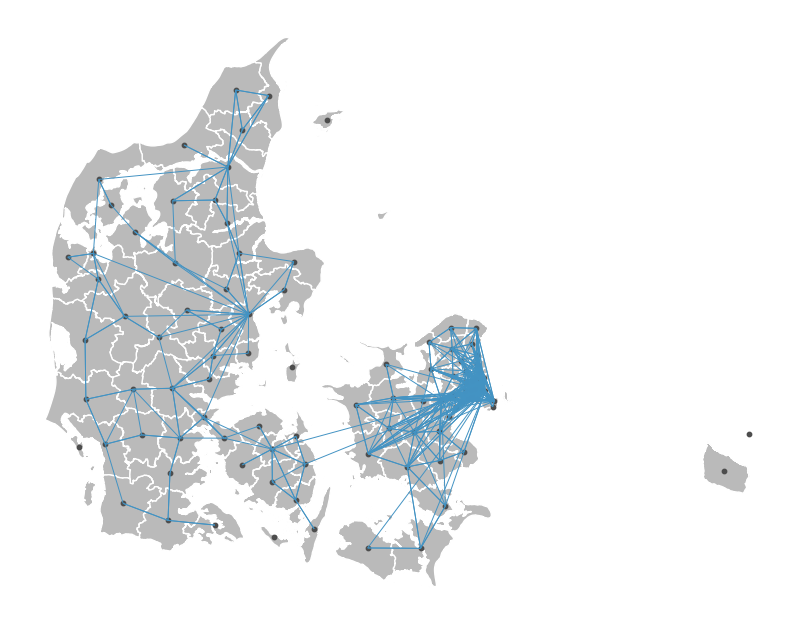

In [24]:
plot_spatial_weights(w,boundaries, indexed_on="Kommune" )

In [16]:
# Prune municipalities where no flow exists
df_elec_prune = df_elec_bound[df_elec_bound.index.isin(neighbors.keys())]
df_elec_prune["weights"] = weights.lag_spatial(w, df_elec_prune[VARIABLE_STD])
df_elec_prune[[ VARIABLE_STD, 'weights']].head()

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


income_std   weights
Kommune                      
665       -0.271982 -0.342385
810       -0.564637 -0.271247
851       -0.493804 -0.133430
607       -0.091377 -0.226621
316       -0.227655 -0.304224

<Axes: >

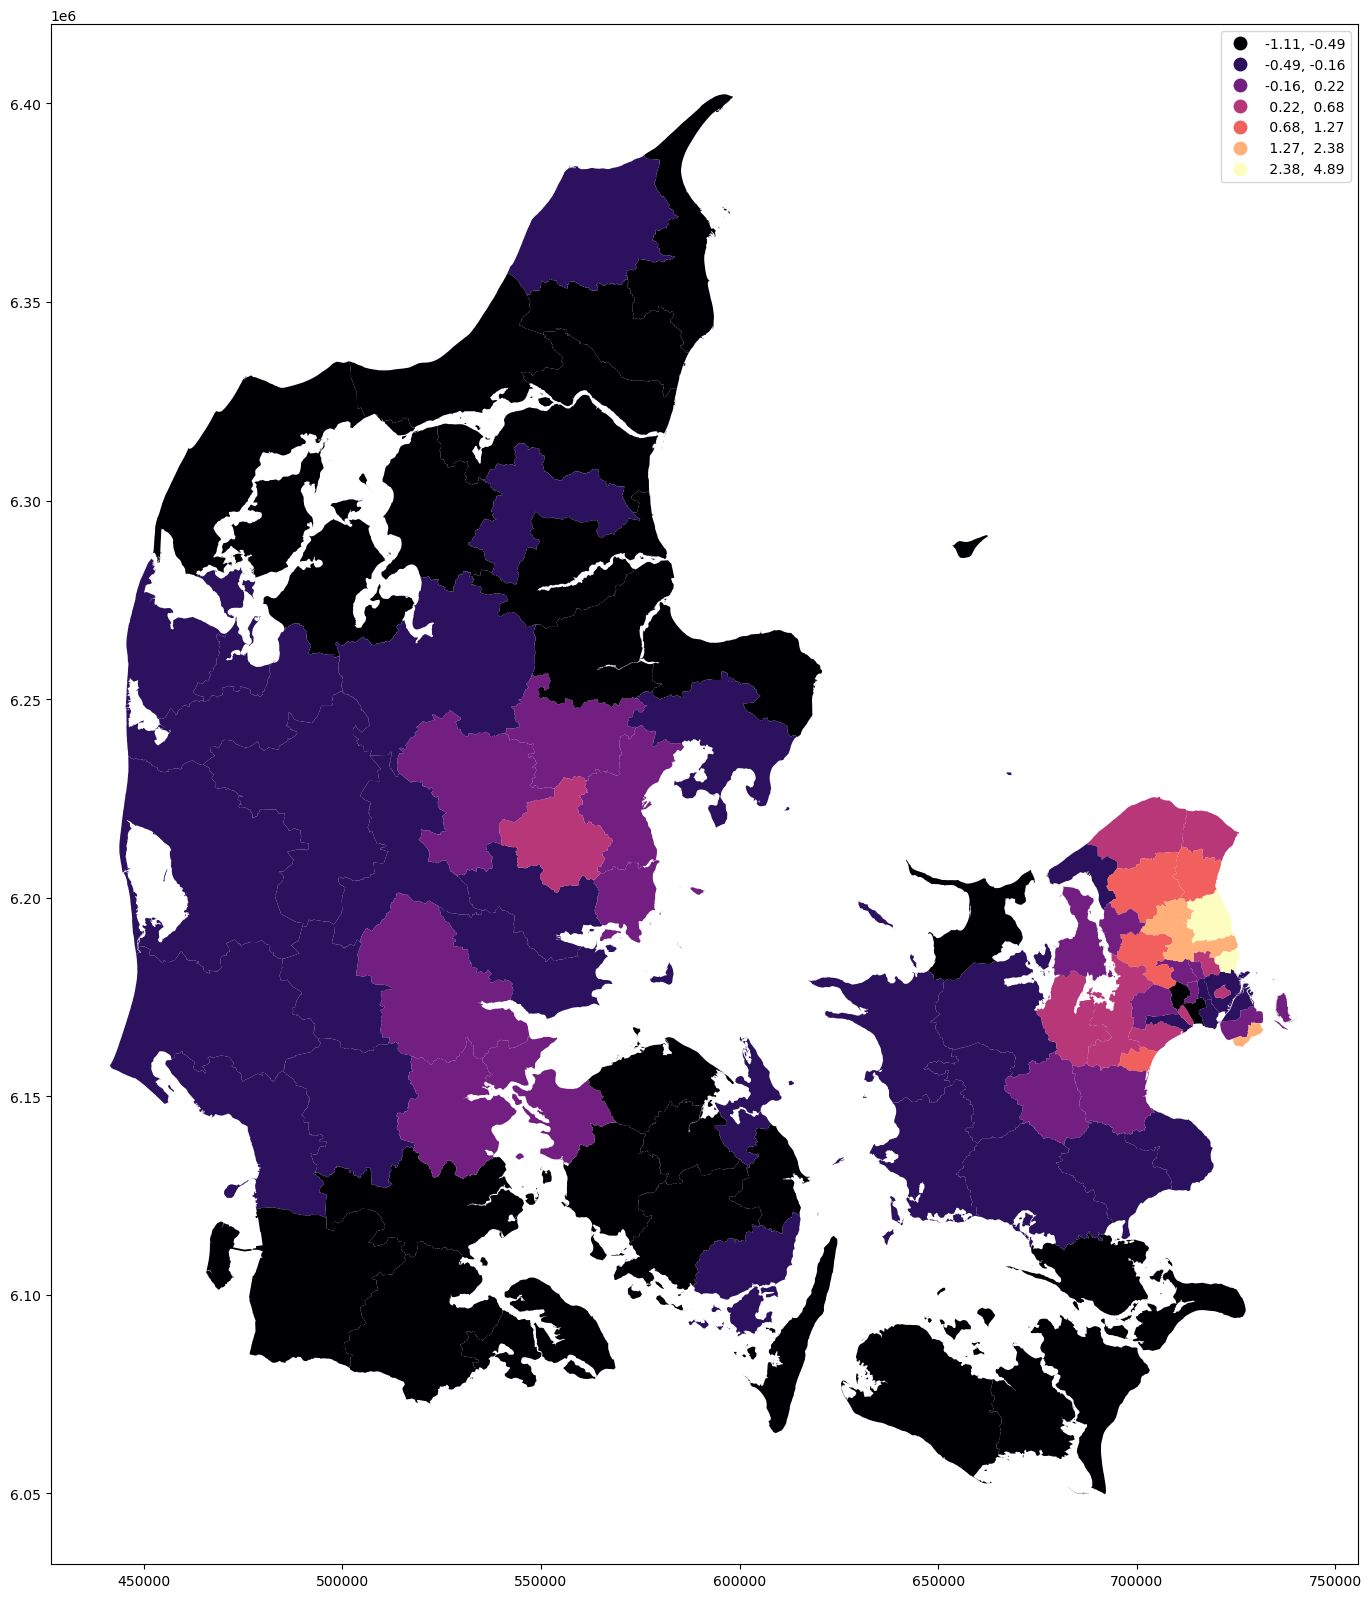

In [17]:
df_elec_prune.plot(column=VARIABLE_STD,
                   scheme="natural_breaks",
                   k=7,
                   cmap="magma",
                   legend=True,
                   figsize=(20, 20),
)

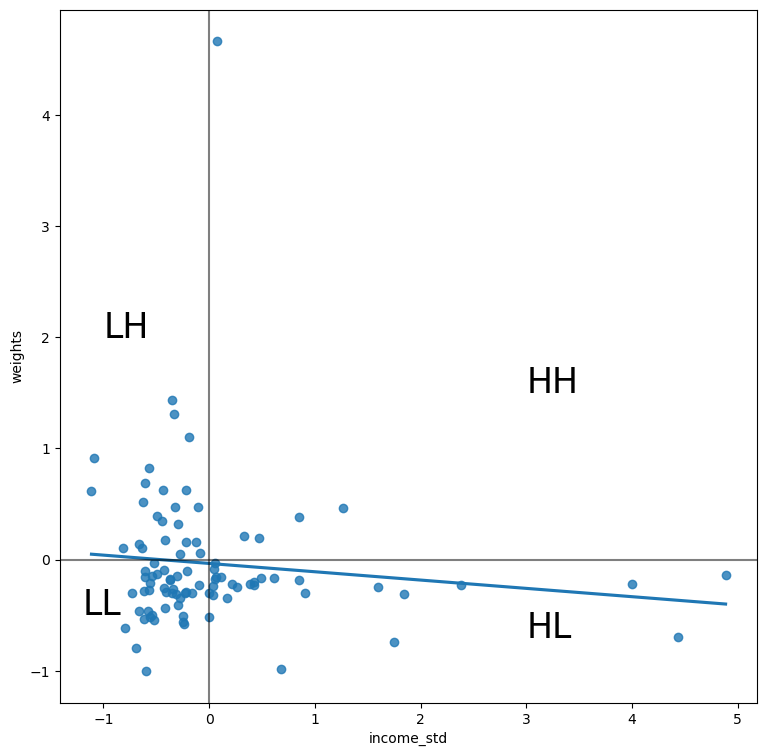

In [25]:
# Visualise with a Moran Plot

f, ax = plt.subplots(1, figsize=(9, 9))

# regression plot (function from seaborn):
sns.regplot(x=VARIABLE_STD, y='weights', data=df_elec_prune, ci=None)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -0.7, "HL", fontsize=25)
plt.text(-1, 2, "LH", fontsize=25)
plt.text(-1.2, -0.5, "LL", fontsize=25)

plt.show()

Moran's I: -0.07479979249271451
P-value for the Moran's I statistic: 0.16


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


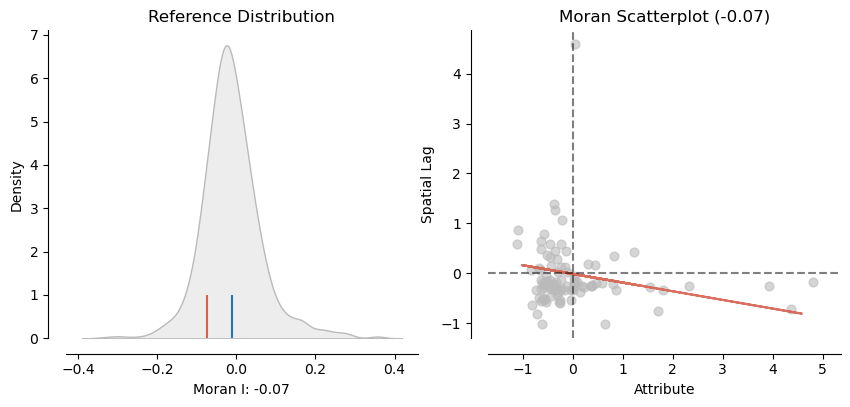

In [31]:
# Calculate Moran's I

mi = esda.Moran(df_elec_prune[VARIABLE_STD], w)

print("Moran's I:", mi.I)

print("P-value for the Moran's I statistic:", mi.p_sim)

# ready-implemented function for Moran scatterplot
plot_moran(mi);

9.68% of the voting areas have a significant value for local Moran's I at p = 0.05


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


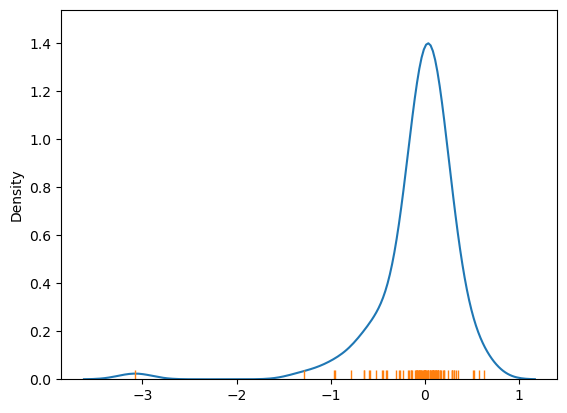

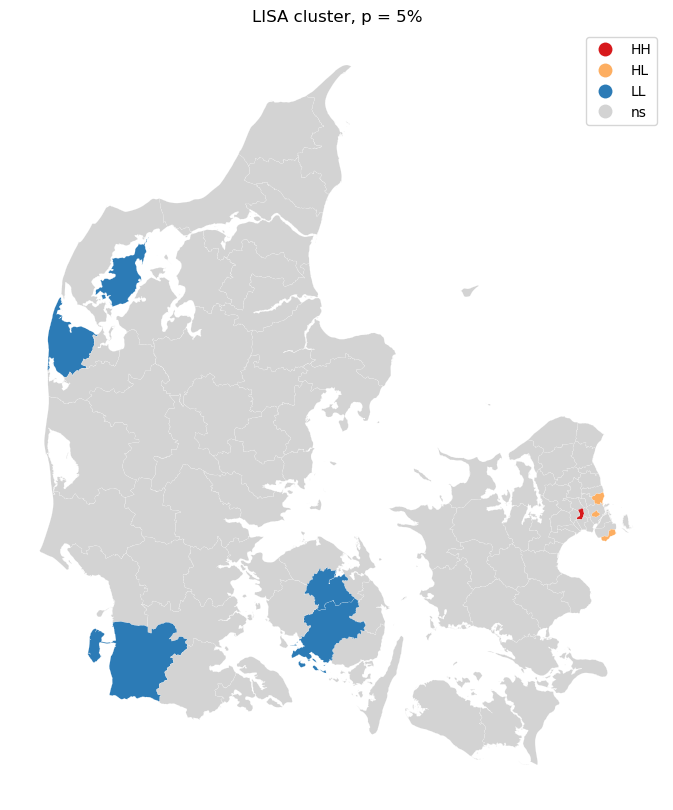

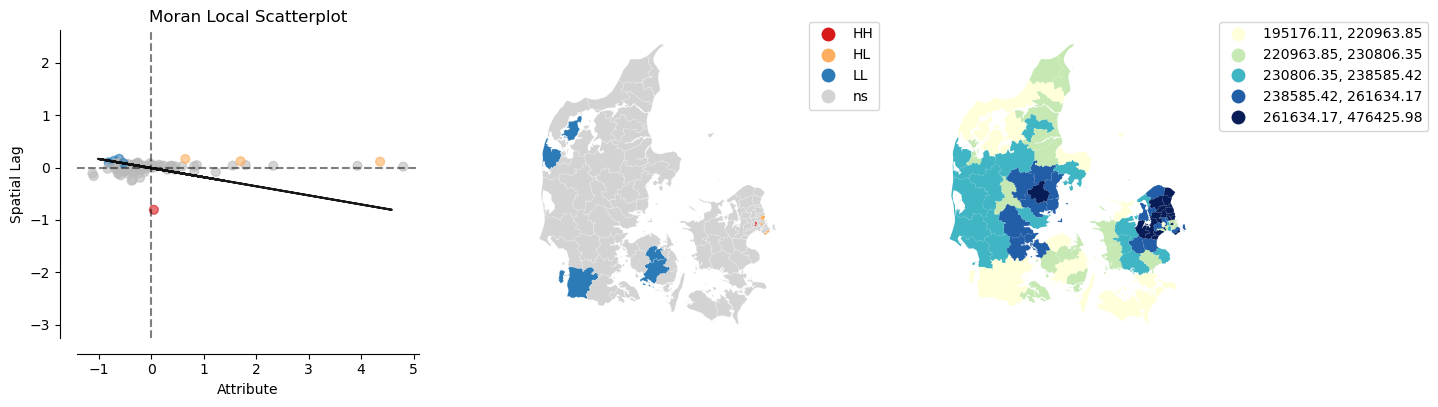

In [29]:
utils.lisa_plots(df_elec_prune, VARIABLE, w)

### Spatial Spatial analysis
This contains baseline of using 5 nearest neighbour for both municipality (kommune) and voting district (local) levels

#### Kommune level

In [33]:
# Create weights check for islands
wk = weights.KNN.from_dataframe(df_elec_bound, k=5)
assert len(wk.islands) == 0

# Standardize spatial weights matrix
wk.transform = 'R' # Using row standardization

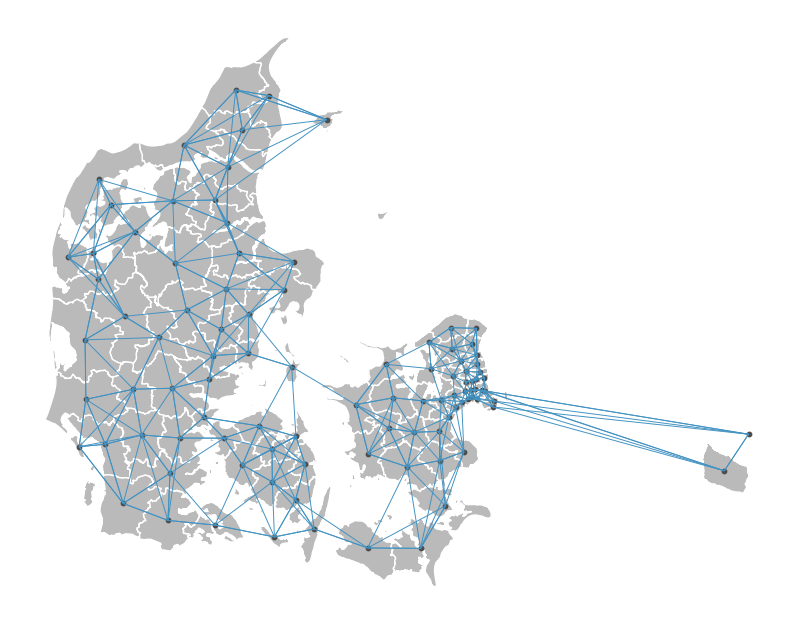

In [34]:
plot_spatial_weights(wk, boundaries, indexed_on='Kommune');

In [37]:
# Create spatial lag of case numbers
df_elec_bound[VARIABLE_W] = weights.lag_spatial(wk, df_elec_bound[VARIABLE_STD])
df_elec_bound[[VARIABLE_STD,VARIABLE_W]].head()

income_std  income_std_w
Kommune                          
665       -0.271982     -0.472541
810       -0.564637     -0.456962
851       -0.493804     -0.546245
607       -0.091377     -0.197656
316       -0.227655     -0.187329

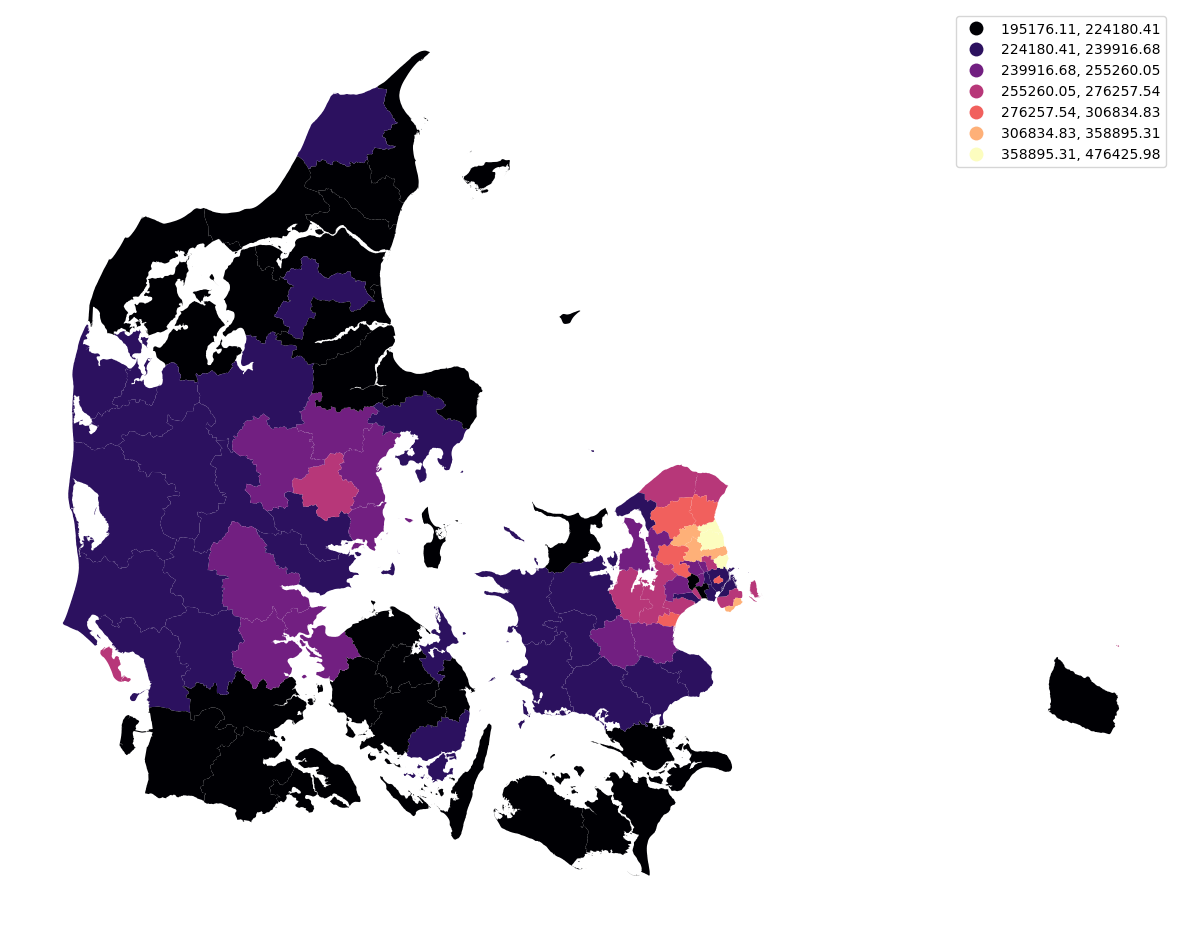

In [36]:
ax = df_elec_bound.plot(column=VARIABLE, 
             scheme='natural_breaks', 
             k=7, 
             cmap='magma', 
             legend=True, 
             figsize=(15,15))
ax.set_axis_off()

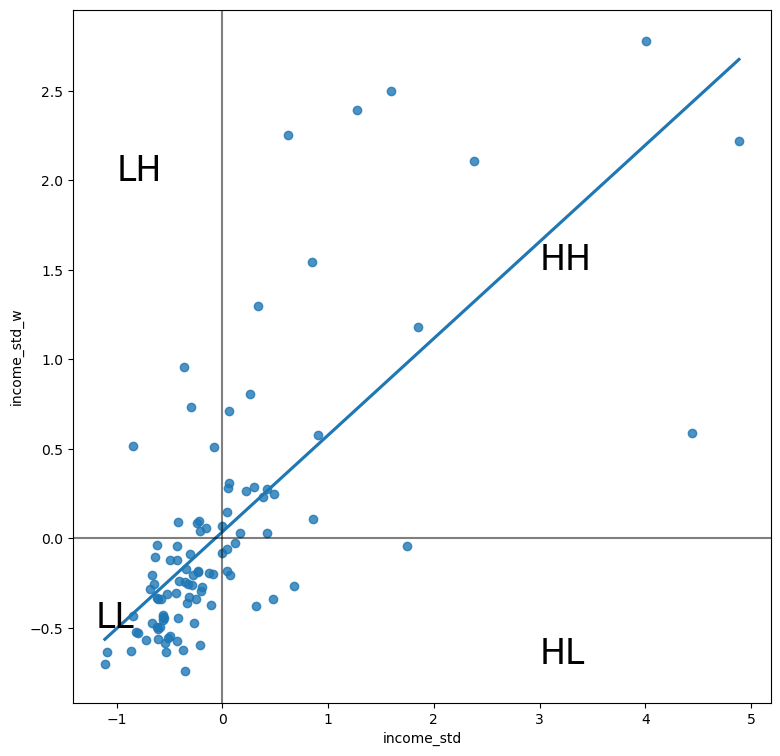

In [38]:

utils.plot_morans(VARIABLE_STD, VARIABLE_W, df_elec_bound)

Moran's I: 0.5399040067333517
P-value for the Moran's I statistic: 0.001


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


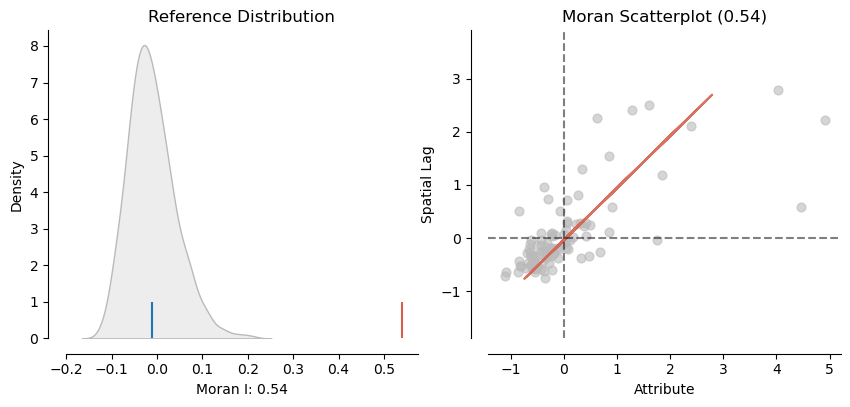

In [39]:
utils.plot_morans_2(df_elec_bound, VARIABLE, wk)


27.27% of the voting areas have a significant value for local Moran's I at p = 0.05


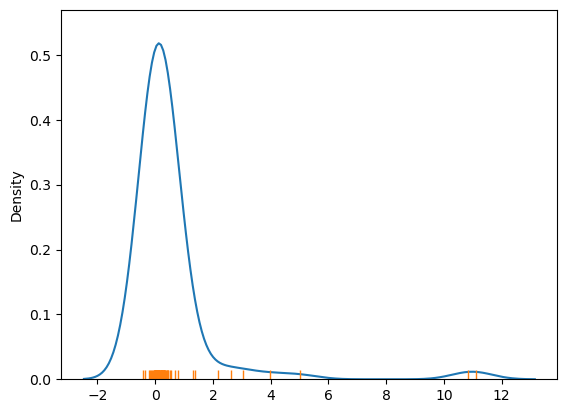

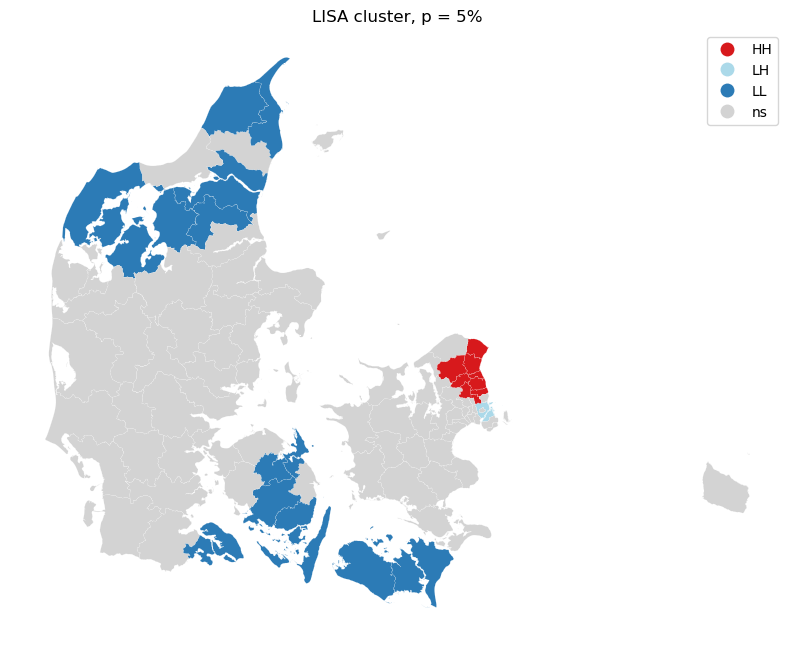

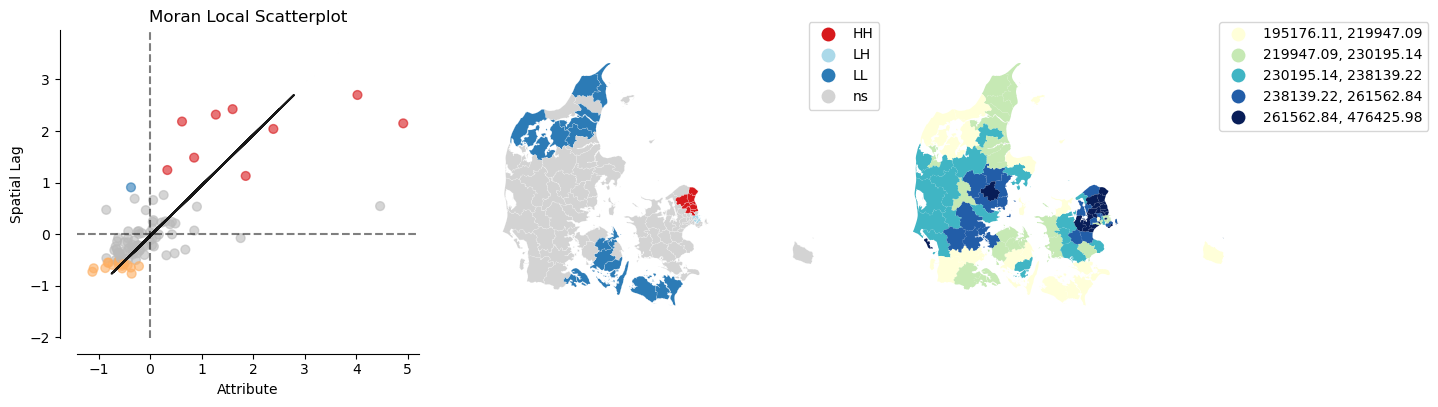

In [40]:
utils.lisa_plots(df_elec_bound, VARIABLE, wk)

#### Voting district level

In [24]:
# Create weights and check for islands
wk = weights.KNN.from_dataframe(df_elec_bound_local, k=5)
assert len(wk.islands) == 0

# Standardize spatial weights matrix
wk.transform = 'R' # Using row standardization

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


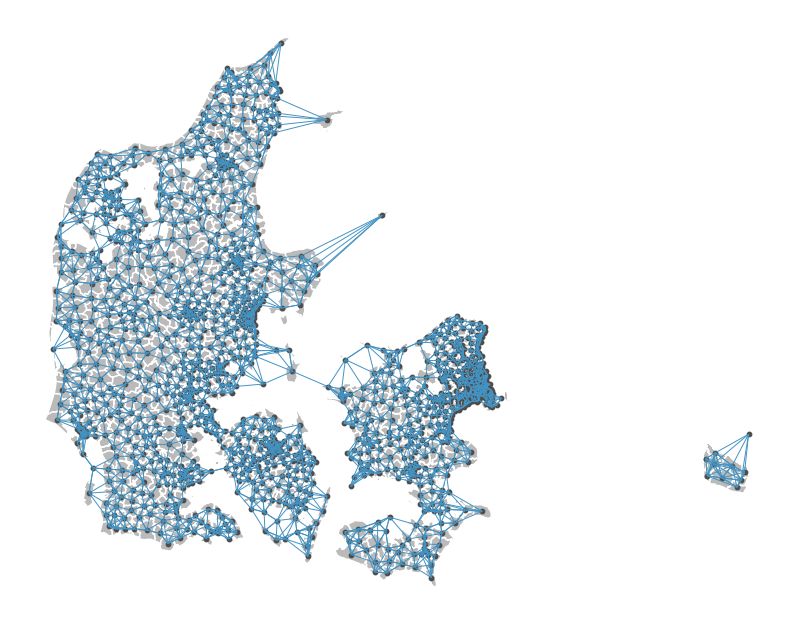

In [25]:
plot_spatial_weights(wk, df_elec_bound_local.reset_index(), indexed_on='kommune_valg');

In [26]:
# Create spatial lag of case numbers
df_elec_bound_local[VARIABLE_W] = weights.lag_spatial(wk, df_elec_bound_local[VARIABLE_STD])
df_elec_bound_local[[VARIABLE_STD,VARIABLE_W]].head()

income_std  income_std_w
kommune_valg                          
665_3           0.309690     -0.133115
410_1           0.148678      0.473989
665_8          -0.033071     -0.123974
665_5          -0.399605     -0.359029
665_6          -0.072117     -0.404473

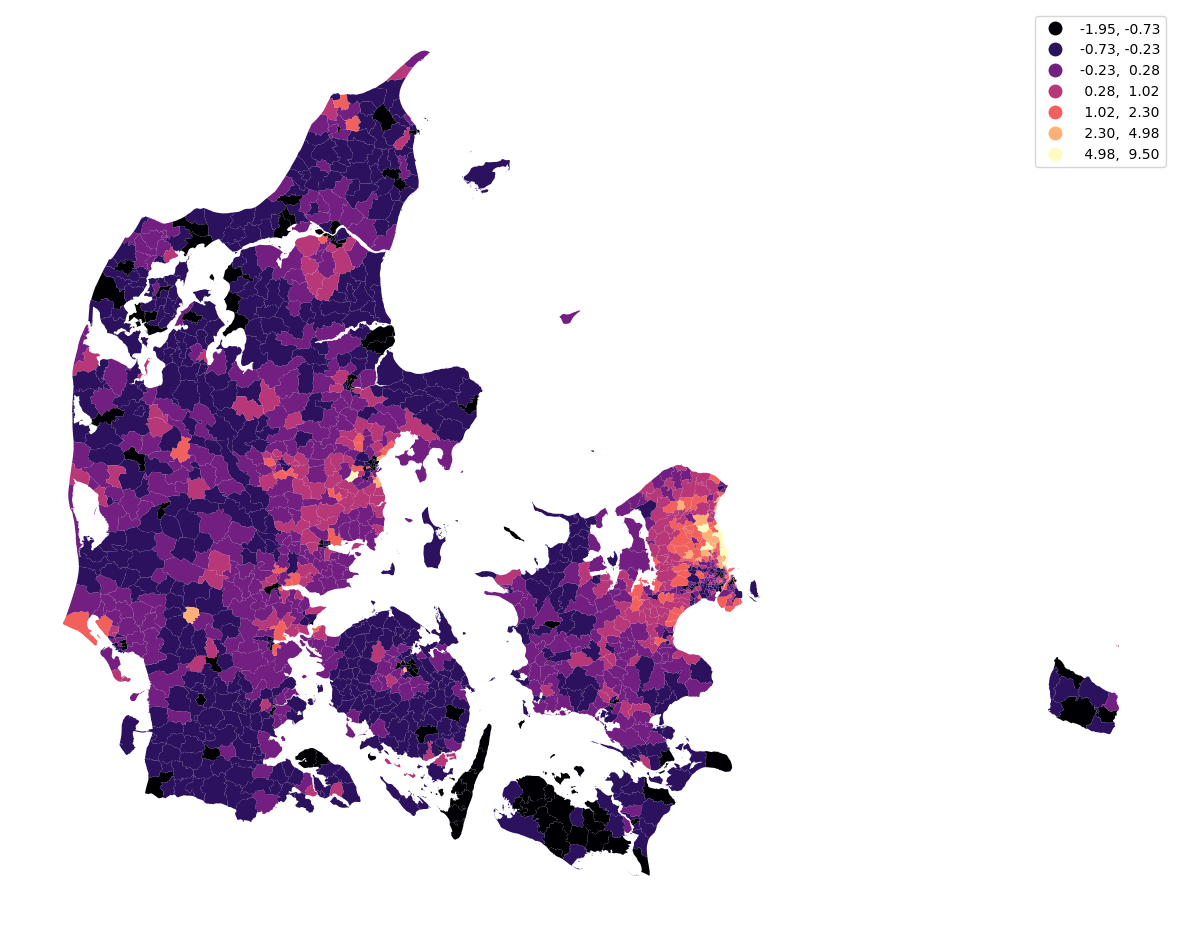

In [27]:
ax = df_elec_bound_local.plot(column=VARIABLE_STD, 
             scheme='natural_breaks', 
             k=7, 
             cmap='magma', 
             legend=True, 
             figsize=(15,15))
ax.set_axis_off()

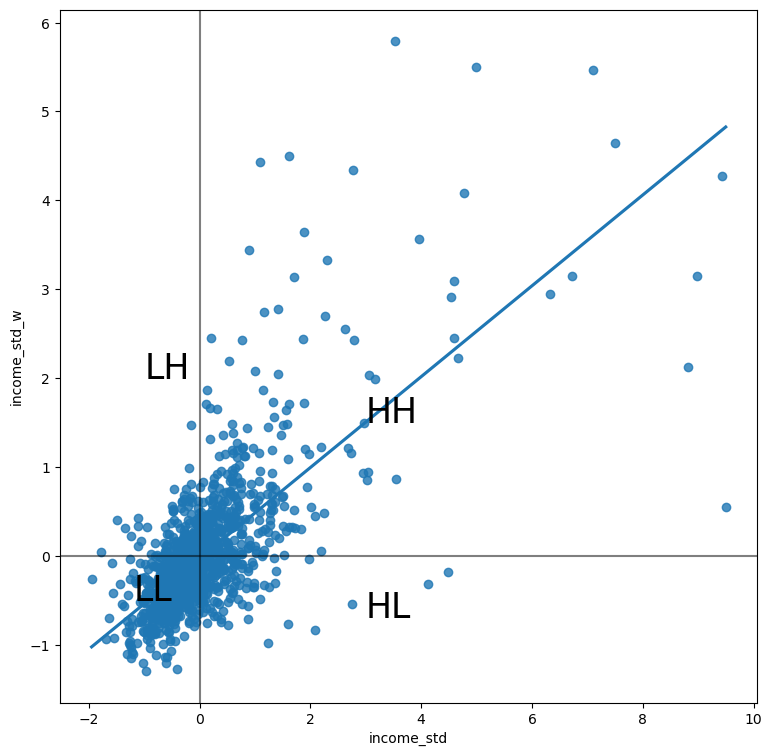

In [28]:
utils.plot_morans(VARIABLE_STD, VARIABLE_W, df_elec_bound_local)

Moran's I: 0.5110101792009891
P-value for the Moran's I statistic: 0.001


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


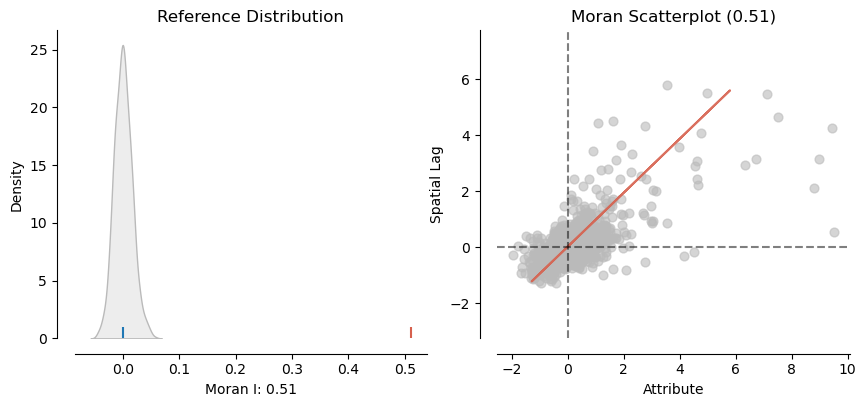

In [29]:
utils.plot_morans_2(df_elec_bound_local, VARIABLE, wk)


24.28% of the voting areas have a significant value for local Moran's I at p = 0.05


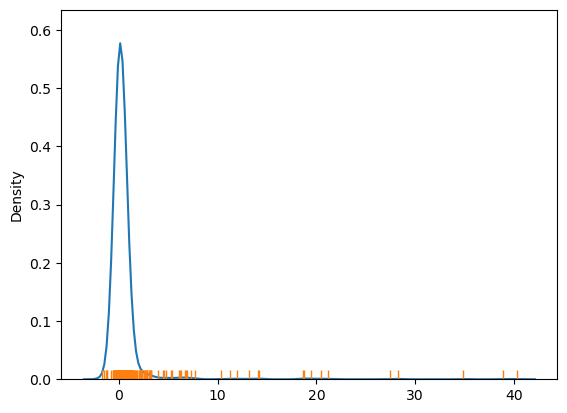

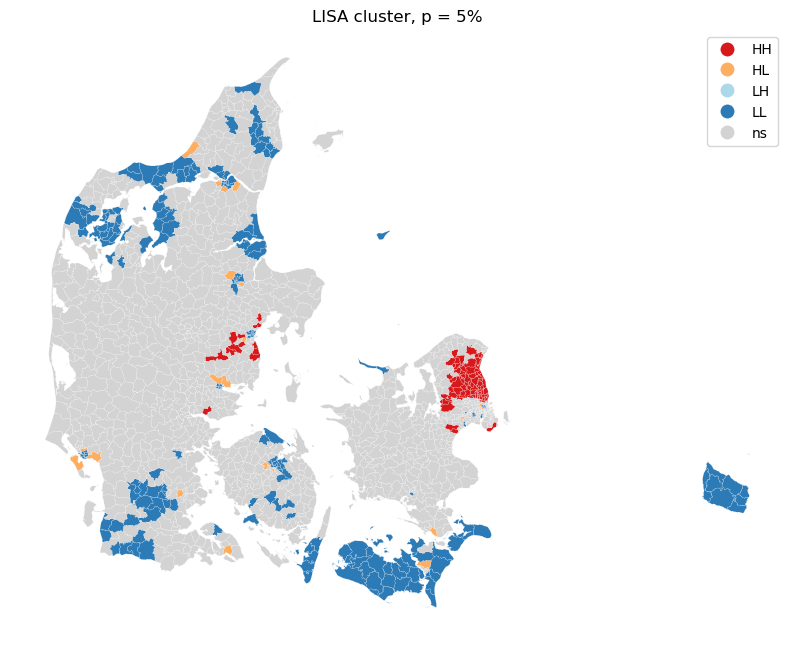

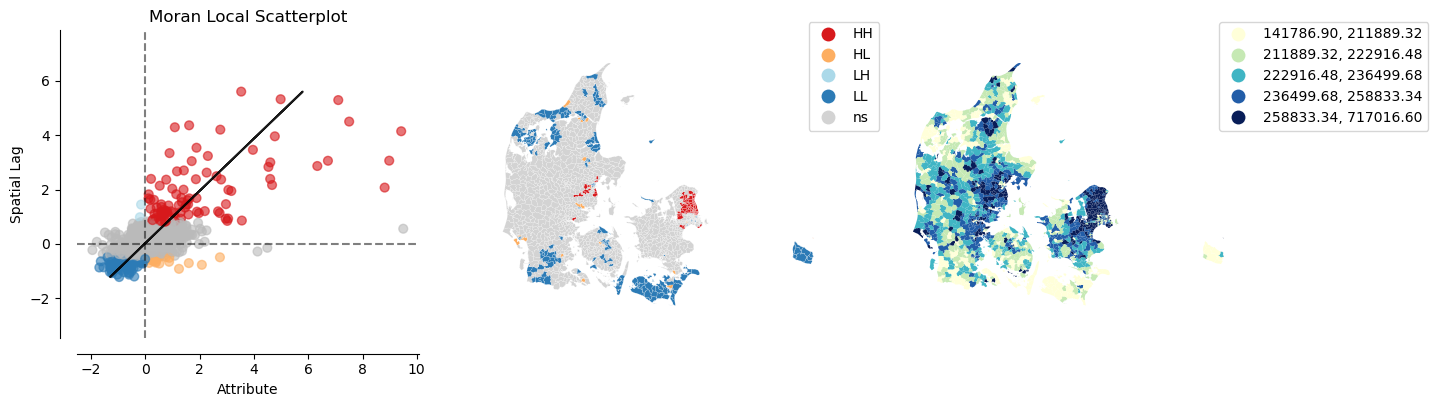

In [30]:
utils.lisa_plots(df_elec_bound_local, VARIABLE, wk)

### Combining neighbours with flow


#### Kommune level

In [31]:
wk = weights.KNN.from_dataframe(df_elec_bound, k=5)
assert len(wk.islands) == 0


In [32]:
# Here we update the weights matrix to use the flow per origin population
min_flow = df_flow[df_flow["source_norm_flow"]> 0 ]["source_norm_flow"].min()
for key, neighborhood in wk.neighbors.items():
    for idx, neighbor in enumerate(neighborhood):
        flow = df_flow.loc[(df_flow["origin"]==key) & (df_flow["destination"]==neighbor), "source_norm_flow"]
        if len(flow) == 1:
            flow = flow.iloc[0]
        # If no flow exists use minimum flow that is not zero (to avoid islands)
        elif len(flow) == 0:
            flow = min_flow
        else:
            print("ERROR")
        wk.weights[key][idx] = flow

wk.transform = 'R' # Using row standardization

In [33]:
df_elec_bound[VARIABLE_W] = weights.lag_spatial(wk, df_elec_bound[VARIABLE_STD])
df_elec_bound[[VARIABLE_STD,VARIABLE_W]].head()

income_std  income_std_w
Kommune                          
665       -0.271982     -0.379858
810       -0.564637     -0.473611
851       -0.493804     -0.514398
607       -0.091377     -0.046712
316       -0.227655     -0.338969

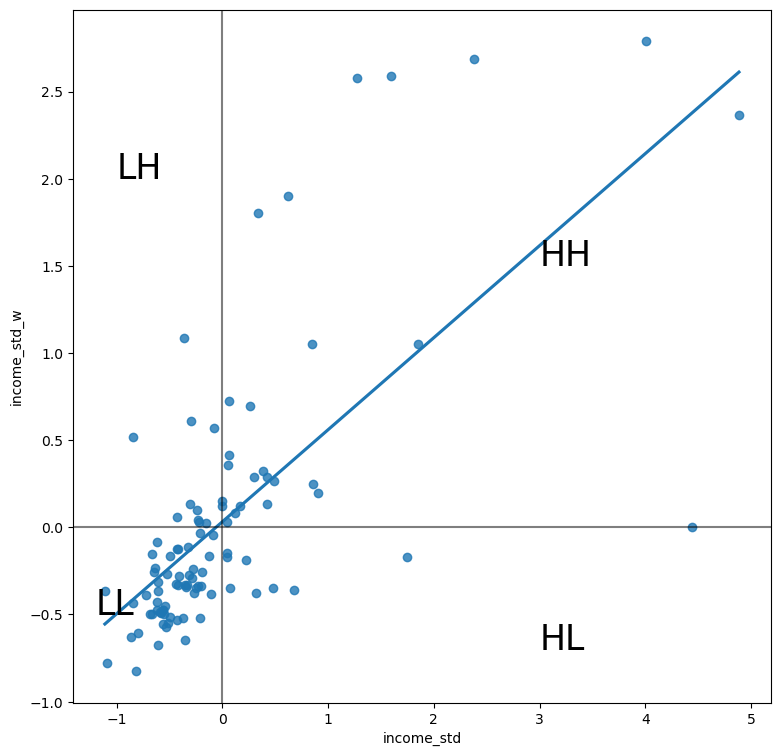

In [34]:
utils.plot_morans(VARIABLE_STD, VARIABLE_W, df_elec_bound)

Moran's I: 0.5279132925352867
P-value for the Moran's I statistic: 0.001


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


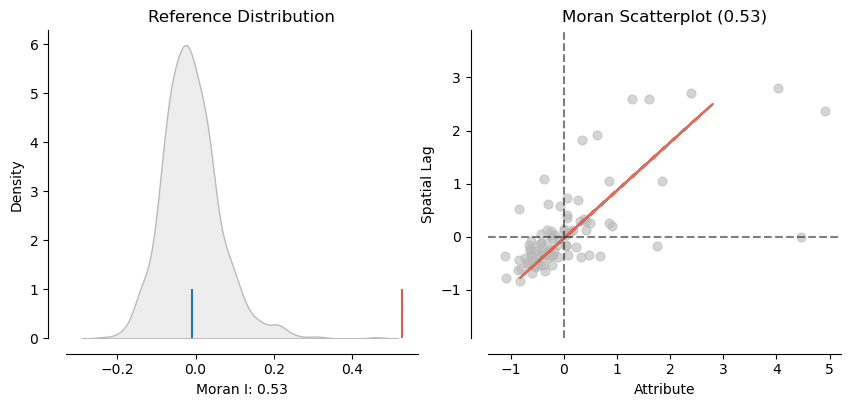

In [35]:
utils.plot_morans_2(df_elec_bound, VARIABLE, wk)


16.16% of the voting areas have a significant value for local Moran's I at p = 0.05


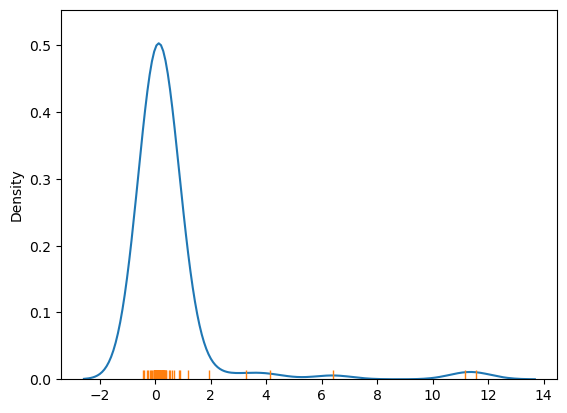

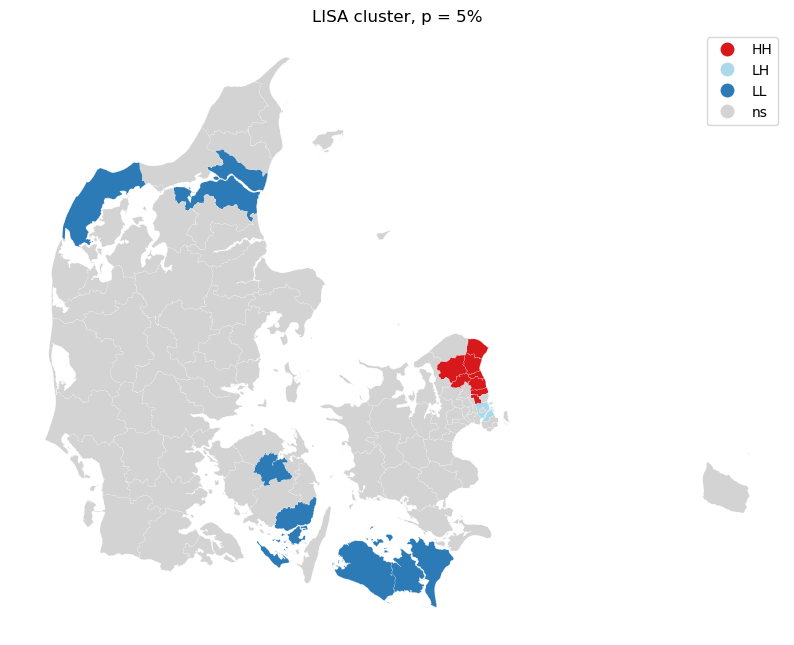

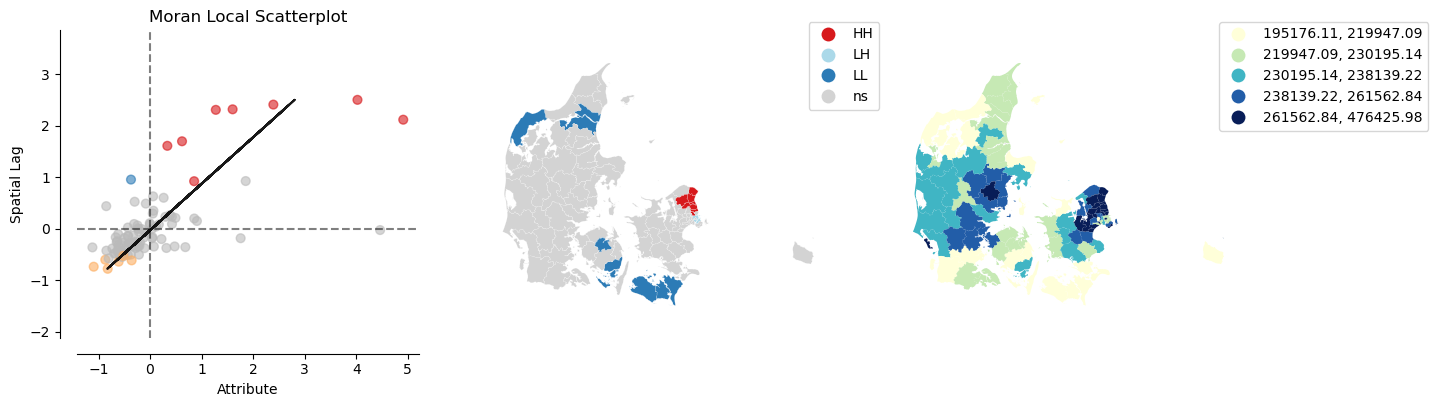

In [36]:
utils.lisa_plots(df_elec_bound, VARIABLE, wk)

#### Voting district level

In [37]:
wk = weights.KNN.from_dataframe(df_elec_bound_local, k=5)
assert len(wk.islands) == 0

c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [38]:
RUN = True # Set to false to read from pickle
if RUN:
    min_flow = df_flow_local[df_flow_local["source_norm_flow"]> 0 ]["source_norm_flow"].min()
    for key, neighborhood in tqdm(wk.neighbors.items()):
        for idx, neighbor in enumerate(neighborhood):
            flow = df_flow.loc[(df_flow_local["origin"]==key) & (df_flow_local["destination"]==neighbor), "source_norm_flow"]
            if len(flow) == 1:
                flow = flow.iloc[0]
            # If no flow exists use minimum flow that is not zero (to avoid islands)
            elif len(flow) == 0:
                flow = min_flow
            else:
                print("ERROR")
            wk.weights[key][idx] = flow

    wk.transform = 'R' # Using row standardization

In [39]:
if RUN:
    with open("data/weights_local_flow.pickle", "wb") as f:
        pickle.dump(wk, f)
else:
    with open("data/weights_local_flow.pickle", "rb") as f:
        wk = pickle.load(f)

In [40]:
df_flow_local.head()

origin destination  flow  origin_population  destination_population  \
0        101_1       101_1  1678              11087                   11087   
1        101_1      101_10    73              11087                   10303   
2        101_1      101_11  3814              11087                   12980   
3        101_1      101_12  2641              11087                    6289   
4        101_1      101_13  1168              11087                    9609   
...        ...         ...   ...                ...                     ...   
1758271  727_9       860_4     0                120                    5196   
1758272  727_9       860_6     0                120                    1393   
1758273  727_9       860_7     0                120                    1274   
1758274  727_9       860_8     0                120                    1286   
1758275  727_9       727_9     0                120                     120   

              distance                               origin_centroid  \
0             0.000000  POINT (4483045.958874151 3625201.1139928102)   
1          5771.467234  POINT (4483045.958874151 3625201.1139928102)   
2          3021.372372  POINT (4483045.958874151 3625201.1139928102)   
3          1332.837348  POINT (4483045.958874151 3625201.1139928102)   
4          3135.348198  POINT (4483045.958874151 3625201.1139928102)   
...                ...                                           ...   
1758271  178095.787794  POINT (4325396.8705781745 3639267.974049059)   
1758272  186134.058728  POINT (4325396.8705781745 3639267.974049059)   
1758273  186897.136745  POINT (4325396.8705781745 3639267.974049059)   
1758274  191647.358471  POINT (4325396.8705781745 3639267.974049059)   
1758275       0.000000  POINT (4325396.8705781745 3639267.974049059)   

                                 destination_centroid  source_norm_flow  \
0        POINT (4483045.958874151 3625201.1139928102)          0.151348   
1        POINT (4482932.727535376 3619430.7576171546)          0.006584   
2        POINT (4482667.425502997 3622203.5477307695)          0.344006   
3         POINT (4483396.557091176 3623915.214974272)          0.238207   
4         POINT (4485162.660510034 3622888.111073298)          0.105349   
...                                               ...               ...   
1758271    POINT (4320425.542247367 3817294.36401537)          0.000000   
1758272  POINT (4317067.657759404 3825215.5796596245)          0.000000   
1758273    POINT (4332830.94416296 3826017.202356148)          0.000000   
1758274  POINT (4333682.211677403 3830736.1519061443)          0.000000   
1758275  POINT (4325396.8705781745 3639267.974049059)          0.000000   

         source_norm_flow_std  
0                    7.443101  
1                    0.259776  
2                   17.002965  
3                   11.753096  
4                    5.160549  
...                       ...  
1758271             -0.066943  
1758272             -0.066943  
1758273             -0.066943  
1758274             -0.066943  
1758275             -0.066943  

[1758276 rows x 10 columns]

In [41]:
df_elec_bound_local[VARIABLE_W] = weights.lag_spatial(wk, df_elec_bound_local[VARIABLE_STD])
df_elec_bound_local[[VARIABLE_STD,VARIABLE_W]].head()

income_std  income_std_w
kommune_valg                          
665_3           0.309690     -0.133115
410_1           0.148678      0.473989
665_8          -0.033071     -0.123974
665_5          -0.399605     -0.359029
665_6          -0.072117     -0.404473

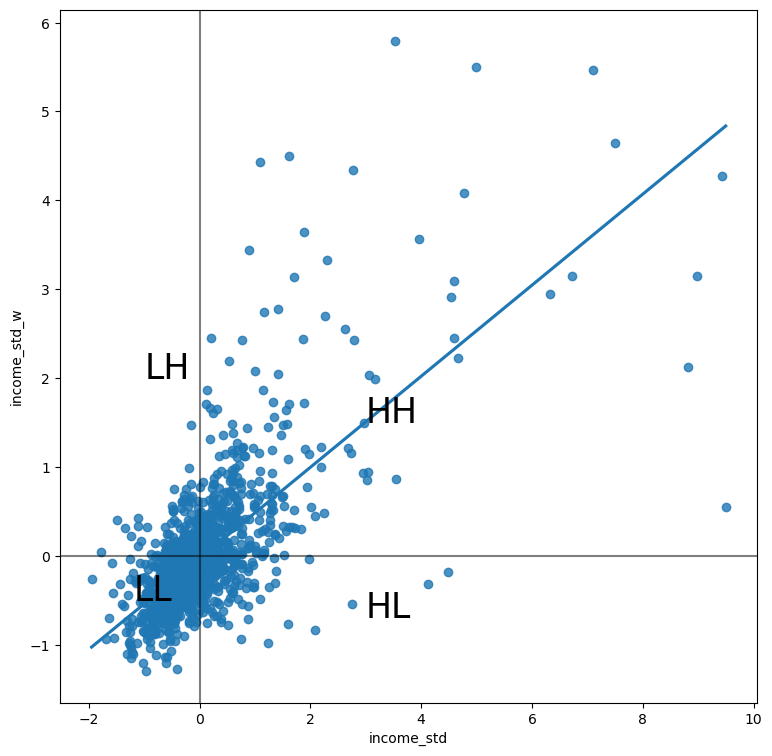

In [42]:
utils.plot_morans(VARIABLE_STD, VARIABLE_W, df_elec_bound_local)

Moran's I: 0.5121726831684478
P-value for the Moran's I statistic: 0.001


c:\Users\Johan\Anaconda3\envs\gds_py\lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


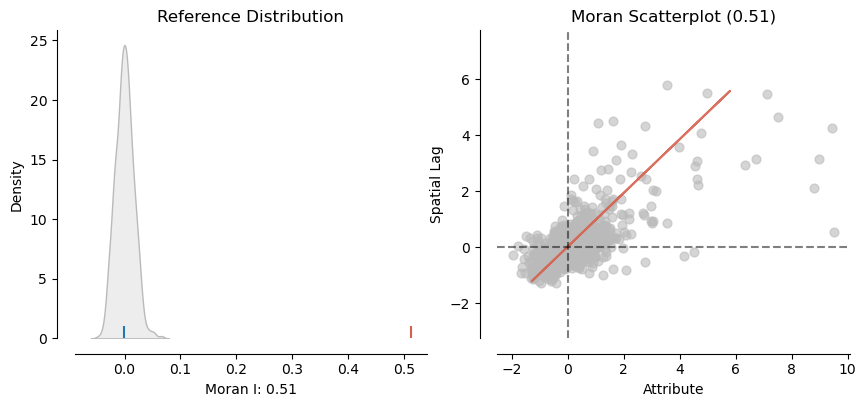

In [43]:
utils.plot_morans_2(df_elec_bound_local, VARIABLE, wk)


##### Lisa

22.33% of the voting areas have a significant value for local Moran's I at p = 0.05


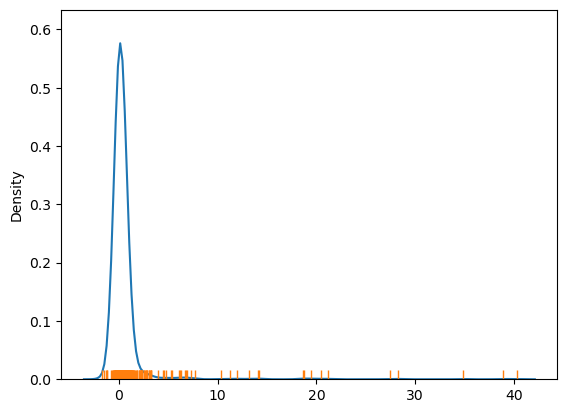

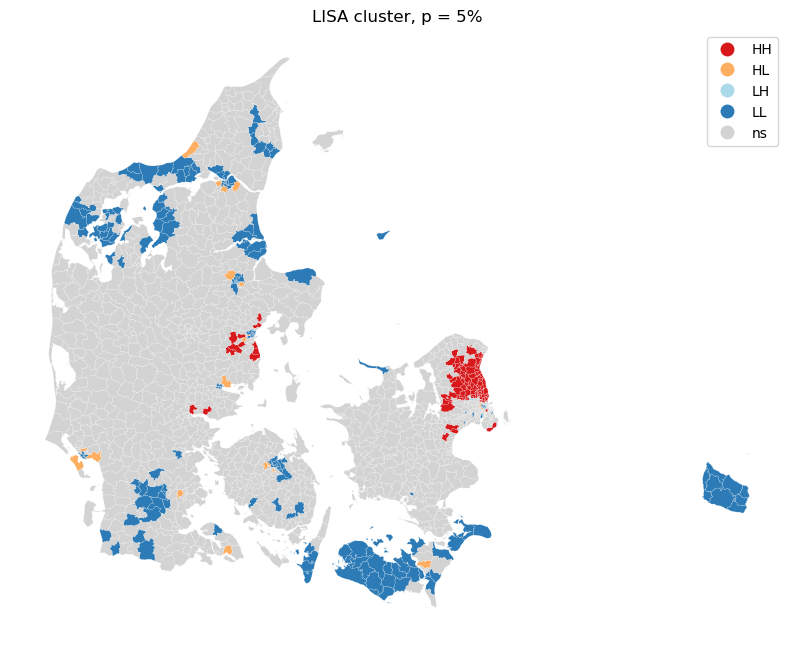

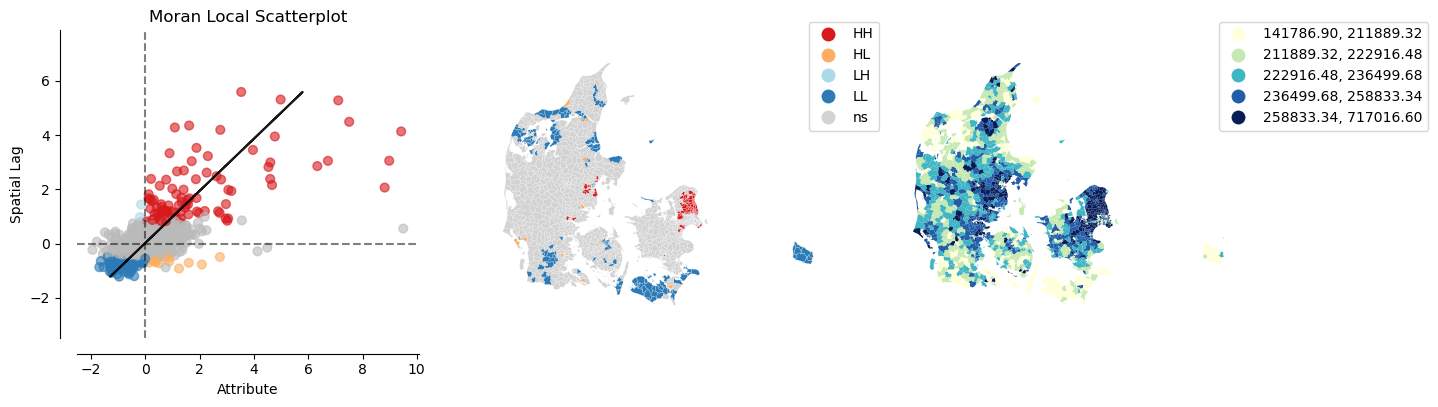

In [44]:
utils.lisa_plots(df_elec_bound_local, VARIABLE, wk)